In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from explore import xgb_rank

# Feature Selection
from explore import get_scaled_df
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7888, 58)

In [5]:
df.columns

Index(['api14', 'lease_name', 'well_number', 'county', 'direction', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'proppant_ppf',
       'prod_method', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'frac_fluid_type', 'first_prod', 'last_prod', 'peak_boepd', 'oil_hist',
       'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long',
       'well_id', 'mid_point_lat', 'mid_point_long', 'sub_basin', 'recovery',
       'recovery_per_foot', 'months_active', 'recovery_per_month',
       'lateral_class', 'vintage', 'vintage_bin', 'encoded_direction',
       'encoded_frac_fluid_type', 'encoded_county', 'encoded_oper',
       'encoded_formation', 'encoded_lateral_class', 'scaled_direction',
       'scaled_frac_fluid_type', 'scaled_county', 'scaled_oper',
       'scaled_formation', 'scaled_lateral_class', 'scaled_proppant_ppf',
       'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 'scaled_frac_stages',
       'scaled_gor_hist', 'scaled_tvd', 'scale

### XGBoost Feature Recommender

In [6]:
feature_list, scaled_features, importance_df = xgb_rank(df,df.recovery,feature_percent=80,mode='gain')
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'formation',
 'mid_point_lat',
 'frac_stages',
 'frac_fluid_gpf']

In [7]:
scaled_features

['scaled_tvd',
 'scaled_vintage',
 'scaled_gross_perfs',
 'scaled_mid_point_long',
 'scaled_formation',
 'scaled_mid_point_lat',
 'scaled_frac_stages',
 'scaled_frac_fluid_gpf']

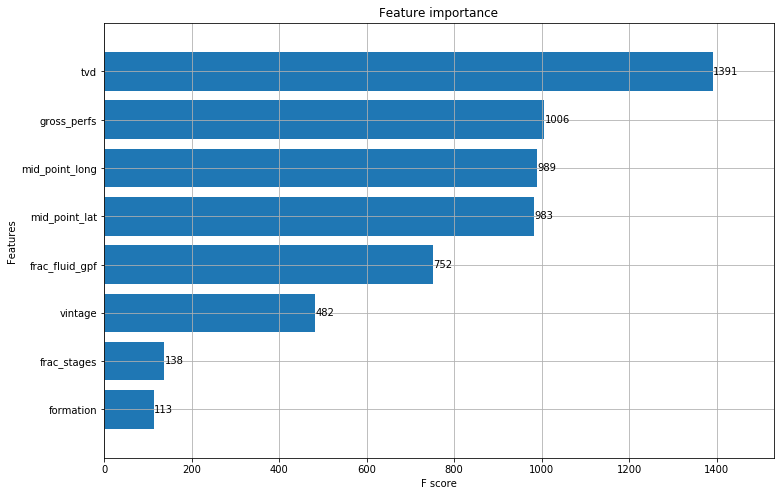

In [8]:
xgb_df = get_scaled_df(df).drop(columns=['recovery'])
xgb_df = xgb_df[feature_list]

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [9]:
importance_df

,rank,feature,gain,cum_sum,cum_perc
0,1.0,tvd,111747.13,111747.13,18.48
1,2.0,vintage,81829.07,193576.20,32.01
2,3.0,gross_perfs,60923.92,254500.12,42.08
3,4.0,mid_point_long,56599.64,311099.76,51.44
4,5.0,formation,54831.63,365931.39,60.51
5,6.0,mid_point_lat,53751.73,419683.12,69.39
6,7.0,frac_stages,30897.07,450580.19,74.50
7,8.0,frac_fluid_gpf,29834.98,480415.17,79.44
8,9.0,oper,26756.07,507171.24,83.86
9,10.0,gor_hist,22836.87,530008.11,87.64


In [10]:
sorted_list = ['tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'formation', 'direction']

<BarContainer object of 7 artists>

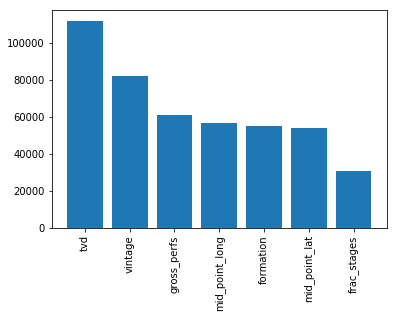

In [11]:
plt.xticks(rotation=90)
plt.bar(importance_df.feature[:7], importance_df.gain[:7])

# Test Harness and Options

### Results for the entire dataframe to use as a baseline before clustering

In [12]:
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'formation',
 'mid_point_lat',
 'frac_stages',
 'frac_fluid_gpf']

In [13]:
xfeatures = ['tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'encoded_formation', 'encoded_direction'] 
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 121.13355809657064
R2 score of training set is 0.24453679434674602


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.24790944 0.23238562 0.24118049]


The model performance for the test set
-------------------------------------------
RMSE of test set is 126.68133259505764
R2 score of test set is 0.22747178762427767




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 120.99203978563916
R2 score of training set is 0.24630095329385648


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.24990806 0.23373695 0.24276387]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

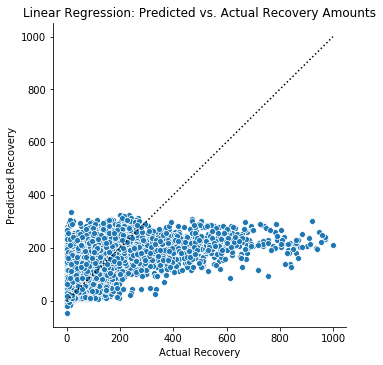

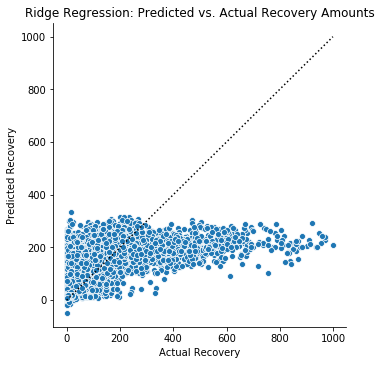

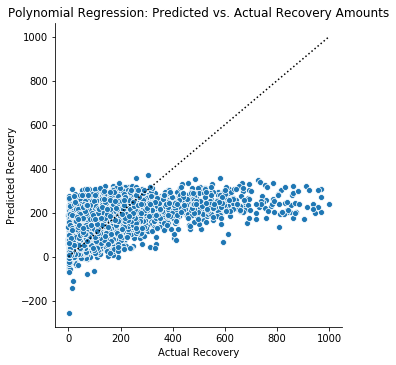

In [14]:
model.run_models(df, xfeatures, yfeature, 0.80, 'full')

**Let's Cluster by our Top Seven features per our XGBoost function**

In [15]:
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'formation',
 'mid_point_lat',
 'frac_stages',
 'frac_fluid_gpf']

In [16]:
scaled_features

['scaled_tvd',
 'scaled_vintage',
 'scaled_gross_perfs',
 'scaled_mid_point_long',
 'scaled_formation',
 'scaled_mid_point_lat',
 'scaled_frac_stages',
 'scaled_frac_fluid_gpf']

#### Had to use encoded_direction:

In [17]:
col_list = scaled_features

**We now have a new dataframe with an added column "cluster_id"**

In [18]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [19]:
df.cluster_id.value_counts()

0    4809
1    1737
2    1342
Name: cluster_id, dtype: int64

**Let's take a look at the differences between the clusters**

In [20]:
df.groupby('cluster_id')['tvd', 'vintage', 'gross_perfs', 'mid_point_long', 'mid_point_lat', 'formation', 'direction'].describe().T

cluster_id                       0             1             2
tvd            count   4809.000000   1737.000000   1342.000000
               mean    8205.669578   8727.503742    404.982116
               std     1279.927766   2586.107885   1333.709684
               min        0.000000      0.000000      0.000000
               25%     7151.000000   6632.000000      0.000000
               50%     8311.000000   8896.000000      0.000000
               75%     9309.000000  11084.000000      0.000000
               max    13153.000000  13434.000000   8778.000000
vintage        count   4809.000000   1737.000000   1342.000000
               mean    2014.707839   2013.397812   1998.919523
               std        1.708506      2.830881     13.238514
               min     2001.000000   1995.000000   1958.000000
               25%     2014.000000   2012.000000   1997.000000
               50%     2015.000000   2014.000000   2000.000000
               75%     2016.000000   2015.000000   2009.000000
               max     2018.000000   2017.000000   2018.000000
gross_perfs    count   4809.000000   1737.000000   1342.000000
               mean    7500.680599   4430.168682   1084.064083
               std     1835.654081   1418.291399   1140.921923
               min      570.000000    610.000000      4.000000
               25%     6555.000000   3871.000000    221.250000
               50%     7517.000000   4325.000000    889.500000
               75%     8777.000000   4788.000000   1552.750000
               max    13581.000000  10065.000000  10460.000000
mid_point_long count   4809.000000   1737.000000   1342.000000
               mean    -101.656029   -103.103214   -101.685681
               std        0.402529      0.655102      0.402393
               min     -103.732848   -104.340768   -103.619589
               25%     -101.980274   -103.632274   -101.903707
               50%     -101.627622   -103.035786   -101.647007
               75%     -101.351423   -102.674132   -101.335749
               max     -100.691821   -101.003982   -100.772283
mid_point_lat  count   4809.000000   1737.000000   1342.000000
               mean      31.583510     32.035979     31.768637
               std        0.422545      0.497860      0.359276
               min       30.725406     30.591857     30.447167
               25%       31.239598     31.730258     31.505836
               50%       31.555728     31.934253     31.706736
               75%       31.885606     32.212786     32.098301
               max       32.851294     33.669249     33.639332

In [21]:
df.groupby('cluster_id')['direction'].value_counts()

cluster_id  direction 
0           Horizontal    4807
            Vertical         2
1           Horizontal    1727
            Vertical        10
2           Vertical      1201
            Horizontal     141
Name: direction, dtype: int64

**A few keep takeaways:**

**Cluster 1 (verticals) contains all, and solely, vertical wells**

**Cluster 0 (short_horizontals) contains horizontal wells that tend to be shorter in lateral length/gross perfs**

**Cluster 2 (long_horizontals) contains horizontal wells that tend to be longer in lateral length/gross perfs**

In [22]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### short_horizontals (cluster 0): 4,019 Oberservations -- observation count did not change

In [23]:
short_horizontals = df[df['cluster_id'] == 0]

In [24]:
short_horizontals.shape

(4809, 59)

In [25]:
feature_list, scaled_features, importance_df = xgb_rank(short_horizontals,short_horizontals.recovery,feature_percent=80,mode='gain')
feature_list

['vintage',
 'formation',
 'mid_point_lat',
 'gross_perfs',
 'tvd',
 'mid_point_long',
 'oper',
 'frac_fluid_gpf']

#### Had to use encoded_formation.

In [26]:
xfeatures = ['vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'encoded_oper', 'tvd', 'gor_hist']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 124.06860822282863
R2 score of training set is 0.13992535432038344


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.11506191 0.14437666 0.1552017 ]


The model performance for the test set
-------------------------------------------
RMSE of test set is 125.36971139370839
R2 score of test set is 0.13082485681983602




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 124.04196354584633
R2 score of training set is 0.14029472979265234


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.1141598  0.14092985 0.15481884]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

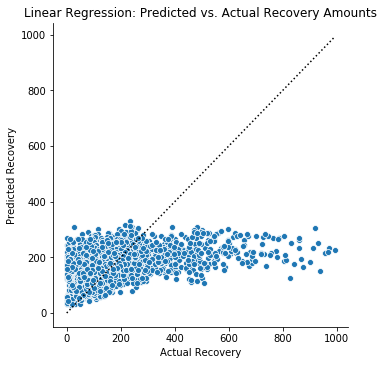

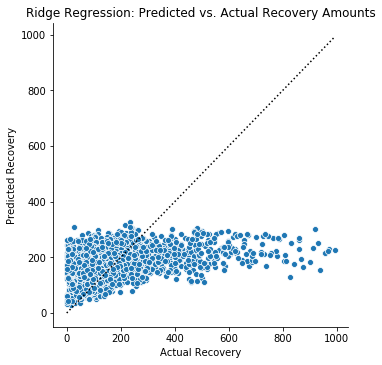

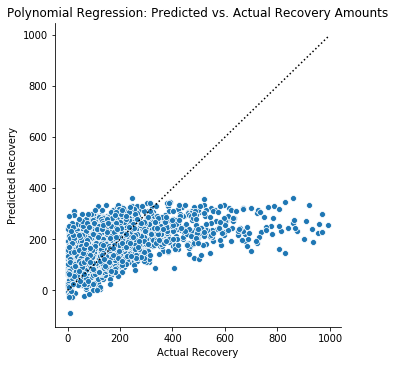

In [27]:
model.run_models(short_horizontals, xfeatures, yfeature, 0.70, 'horizontal_short')

### verticals (cluster 1):  1,224 Observations, down from 1,714 Observations

In [28]:
verticals = df[df['cluster_id'] == 1]

In [29]:
verticals.shape

(1737, 59)

In [30]:
feature_list, scaled_features, importance_df = xgb_rank(verticals, verticals.recovery, feature_percent=80,mode='gain')
feature_list

['mid_point_long',
 'vintage',
 'frac_fluid_gpf',
 'mid_point_lat',
 'oper',
 'tvd',
 'gross_perfs']

#### Had to use encoded_lateral_class and encoded_formation.

In [31]:
xfeatures = ['vintage', 'gor_hist', 'gross_perfs', 'tvd', 'encoded_formation']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 142.64020080968183
R2 score of training set is 0.2201242764022453


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19292884 0.21025446 0.23903066]


The model performance for the test set
-------------------------------------------
RMSE of test set is 142.24171554007071
R2 score of test set is 0.20992144289370118




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 142.0681355388082
R2 score of training set is 0.2263671894397068


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19842852 0.21085567 0.2500377 ]


The model performance for the test set
-------------------------------------------
RMSE of test set is 141

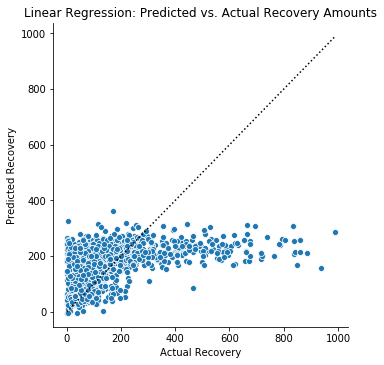

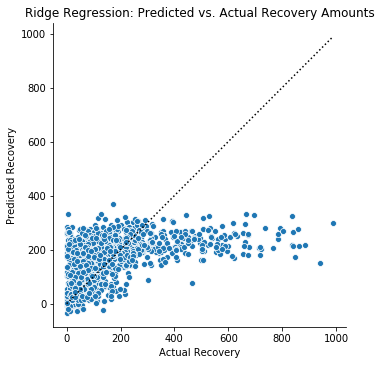

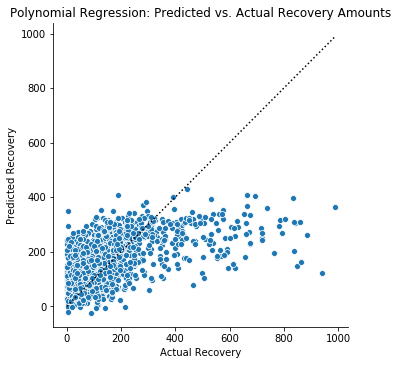

In [32]:
model.run_models(verticals, xfeatures, yfeature, 0.70, 'vertical')

### long_horizontals (cluster 2): 2,565 Observations, up from 1,232 Observations

In [33]:
long_horizontals = df[df['cluster_id'] == 2]

In [34]:
long_horizontals.shape

(1342, 59)

In [35]:
feature_list, scaled_features, importance_df = xgb_rank(long_horizontals,long_horizontals.recovery,feature_percent=80,mode='gain')
feature_list

['vintage', 'direction', 'gross_perfs', 'tvd', 'gor_hist', 'mid_point_long']

#### Did not have to encode any of these features.

In [36]:
xfeatures = ['vintage', 'mid_point_lat', 'encoded_formation', 'gross_perfs', 'mid_point_long', 'tvd', 'frac_fluid_gpf']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 39.5077356158409
R2 score of training set is 0.20159367087767677


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19887655 0.16949464 0.13698109]


The model performance for the test set
-------------------------------------------
RMSE of test set is 37.55225756897197
R2 score of test set is 0.18943284132285076




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 38.33073675148683
R2 score of training set is 0.2484566659240267


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.26375921 0.20420989 0.1778117 ]


The model performance for the test set
-------------------------------------------
RMSE of test set is 36.29

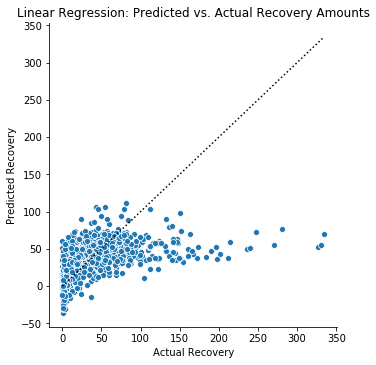

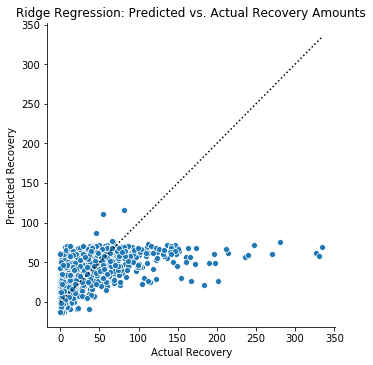

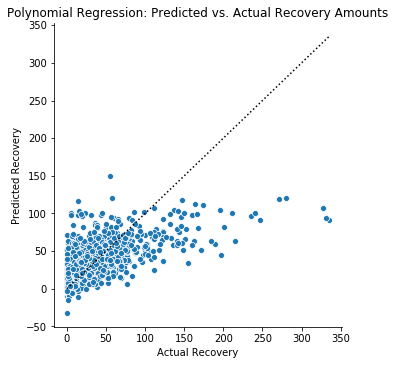

In [37]:
model.run_models(long_horizontals, xfeatures, yfeature, 0.70, 'horizontal_long')

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering